Name: Nathan Dang

Date: 01/28/2019

Applied Machine Learning - DSCI225

Instructor: Prof. Basye

# Lab 2 - Building a Binary Classifier with Kepler Exoplanet Data

This notebook represents a binary classifier predicting ("koi_disposition" == CONFIRMED) given the Kepler Exoplanet Data provided by NASA.

The dataset can be obtained from the following link: https://www.kaggle.com/nasa/kepler-exoplanet-search-results/version/2

## Get the data

To begin with, let's import some important libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Get the dataset from the .csv file.

WARNING: the .csv file needs to be in the same folder as the jupyter notebook in order for the whole thing to work

In [2]:
dataset = pd.read_csv('cumulative.csv')

Now that we have the data to work on, let's take a brief look at it

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
rowid                9564 non-null int64
kepid                9564 non-null int64
kepoi_name           9564 non-null object
kepler_name          2294 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_du

In [4]:
dataset.shape

(9564, 50)

In [5]:
dataset.head(10)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
7,8,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
8,9,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-124.0,3.986,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660
9,10,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-83.0,4.485,0.083,-0.028,0.848,0.033,-0.072,286.99948,48.375790,15.841


In [6]:
# this will be our labels for the classifier
dataset['koi_disposition'].value_counts()

FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: koi_disposition, dtype: int64

## Preprocess the data

For starter, let's drop some columns which contain uncertain values (i.e. they have nothing to do with predicting the labels correctly), non-numerical values. Specifically:

- Columns whose values are non-numerical include 'koi_pdispotition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name', 'kepoi_name'

- Columns whose values contain uncertainty are kepid, rowid, "error columns" (i.e. columns whose names contain "err")

- There is one "special" column that we want to drop, that is, the 'koi_score' because it is a number between 0 and 1 indicating how likely it is that the star has a planet and many of them are actually either 0 or 1 which may cause uncertainty. Also, those whose values are 1 corespond to 'CONFIRMED' (or 1 as in our labels) which will cause biased to our classifier, that is, as long as it sees a 1 in the 'koi_score', it can easily predict 'CONFIRMED'.

The following block of code was adapted from: https://www.kaggle.com/kirktobridge/analyzing-nasa-s-kepler-exoplanet-search-results

In [7]:
# aforementioned columns we don't want
koi_pond = ['koi_pdisposition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name', 'kepoi_name', 'kepid', 'rowid', 'koi_score']

# gonna iterate through the columns of the raw data to add the uncertainty/error ones to the drop-list (koi_pond)
cols = dataset.columns

# to make dropping the error columns easier, I'm just going to go through the whole list and drop every column with 'err' in the name. 
for c in cols:
    if 'err' in c:
        koi_pond.append(c)

# finalize changes, but hold on to the raw data in case we need it later
dataset_dropped = dataset.drop(koi_pond, axis = 1)

print("Dropped:\n\n", koi_pond)
print(f"\nOur original dataset had {dataset.shape[1]} columns.\nIt now has {dataset_dropped.shape[1]} columns.")

Dropped:

 ['koi_pdisposition', 'koi_tce_plnt_num', 'koi_tce_delivname', 'kepler_name', 'kepoi_name', 'kepid', 'rowid', 'koi_score', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol_err1', 'koi_insol_err2', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2']

Our original dataset had 50 columns.
It now has 20 columns.


We have not finised with re-processing our data yet, we need to check for values that are NaN as they also have nothing to do with predicting our labels correctly. The following line of code count the number of missing values (i.e. NaN values) for each column in our data.

In [8]:
dataset_dropped.isna().sum()

koi_disposition      0
koi_fpflag_nt        0
koi_fpflag_ss        0
koi_fpflag_co        0
koi_fpflag_ec        0
koi_period           0
koi_time0bk          0
koi_impact         363
koi_duration         0
koi_depth          363
koi_prad           363
koi_teq            363
koi_insol          321
koi_model_snr      363
koi_steff          363
koi_slogg          363
koi_srad           363
ra                   0
dec                  0
koi_kepmag           1
dtype: int64

Now, we need to take care of those missing values. There are a few options for us to choose, we can drop the entire column with missing values, or we can drop the rows containing missing values, or we can replace the missing values with some other values such as zeros, the mean, or the median (for numerical values) or the most occured values (for non-numerical values). 

Let's choose the third method, filling the missing values with the mean. Luckily, the remained features only contain numerical values (as we dropped all non-numerical atrributes) which is nice. 

In [9]:
dataset_dropped_filled = dataset_dropped.fillna(dataset_dropped.mean())

Let's double check if the missing values were successfully filled just to make sure.

In [10]:
dataset_dropped_filled.isna().sum()

koi_disposition    0
koi_fpflag_nt      0
koi_fpflag_ss      0
koi_fpflag_co      0
koi_fpflag_ec      0
koi_period         0
koi_time0bk        0
koi_impact         0
koi_duration       0
koi_depth          0
koi_prad           0
koi_teq            0
koi_insol          0
koi_model_snr      0
koi_steff          0
koi_slogg          0
koi_srad           0
ra                 0
dec                0
koi_kepmag         0
dtype: int64

Great! Now that we have refined our data, let's have some visulisation of it. The following two methods were adapted from the Kaggle bot which provide as the distribution graphs, the correlation matrix, and the scatter and density plots of our features

https://www.kaggle.com/adrian1acoran/starter-kepler-exoplanet-search-428eadac-f

In [11]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [12]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [13]:
dataset_dropped_filled.head(10)

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,288.75488,48.226200,15.509
5,CONFIRMED,0,0,0,0,11.094321,171.201160,0.538,4.59450,1517.5,3.90,835.0,114.81,66.5,6046.0,4.486,0.972,296.28613,48.224670,15.714
6,CONFIRMED,0,0,0,0,4.134435,172.979370,0.762,3.14020,686.0,2.77,1160.0,427.65,40.2,6046.0,4.486,0.972,296.28613,48.224670,15.714
7,CONFIRMED,0,0,0,0,2.566589,179.554370,0.755,2.42900,226.5,1.59,1360.0,807.74,15.0,6046.0,4.486,0.972,296.28613,48.224670,15.714
8,FALSE POSITIVE,0,1,1,0,7.361790,132.250530,1.169,5.02200,233.7,39.21,1342.0,767.22,47.7,6227.0,3.986,1.958,298.86435,42.151569,12.660
9,CONFIRMED,0,0,0,0,16.068647,173.621937,0.052,3.53470,4914.3,5.76,600.0,30.75,161.9,5031.0,4.485,0.848,286.99948,48.375790,15.841


<b>Observation: </b>Upon looking at the dataframe, we can see that some numerical attributes have very different scale which will reduce the performance of our classifier. Thus, when we finish splitting our data into traning and testing set, we will have to do some feature scaling to make sure that the classifier can achieve the best performance.

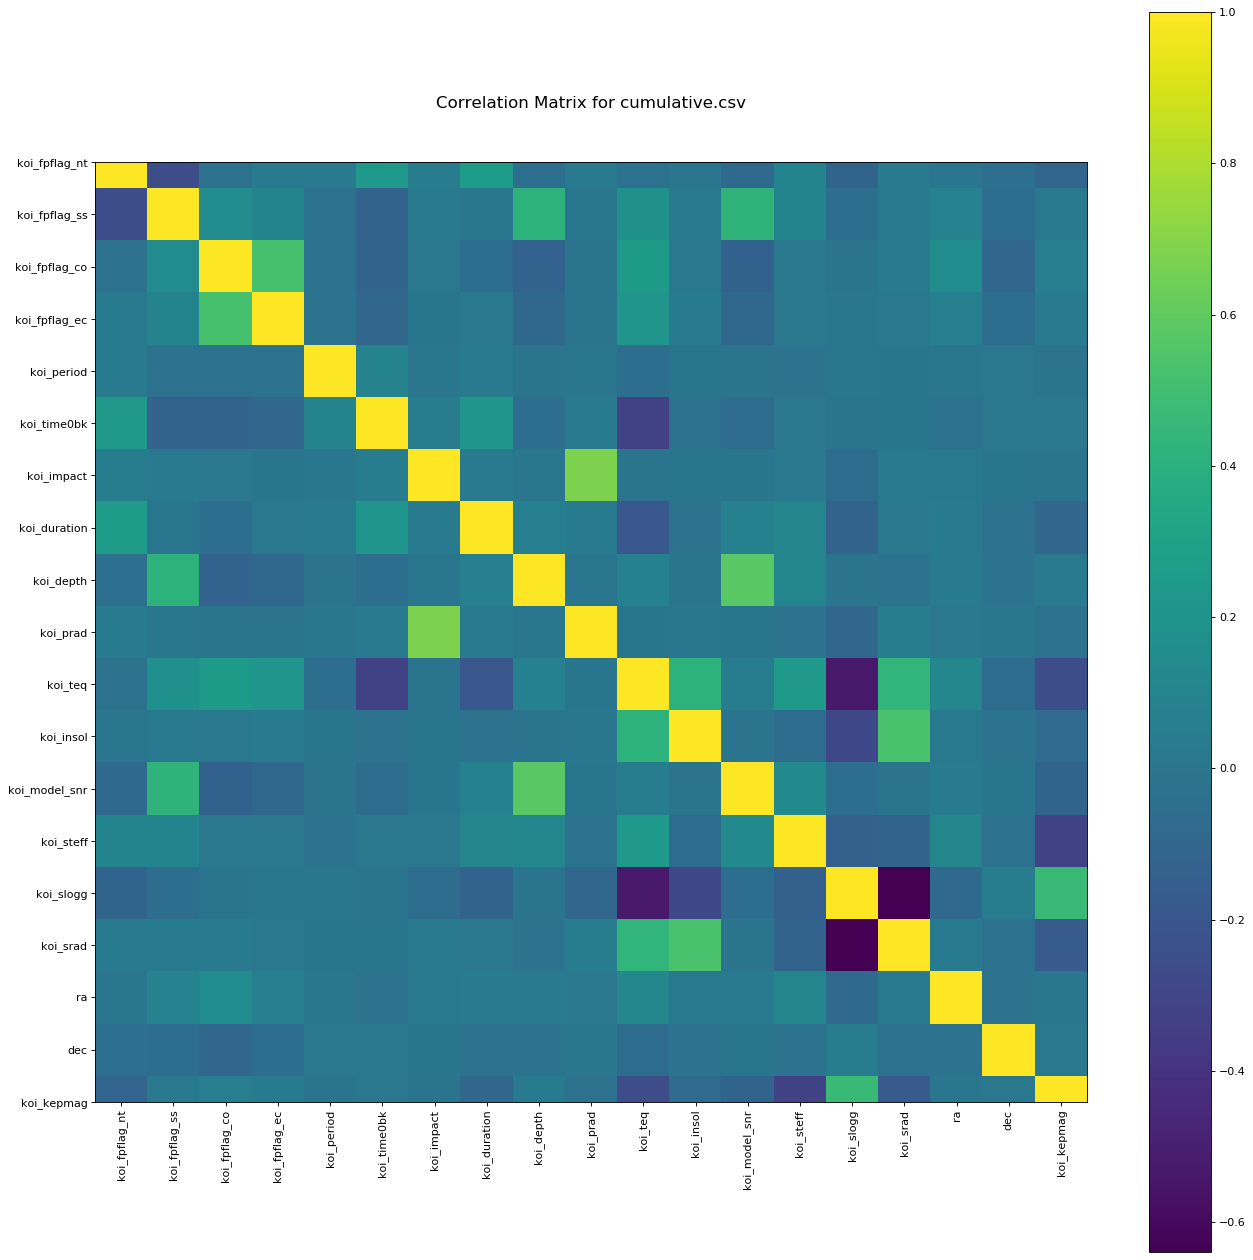

In [14]:
dataset_dropped_filled.dataframeName = 'cumulative.csv'
plotCorrelationMatrix(dataset_dropped_filled, dataset_dropped_filled.shape[1])

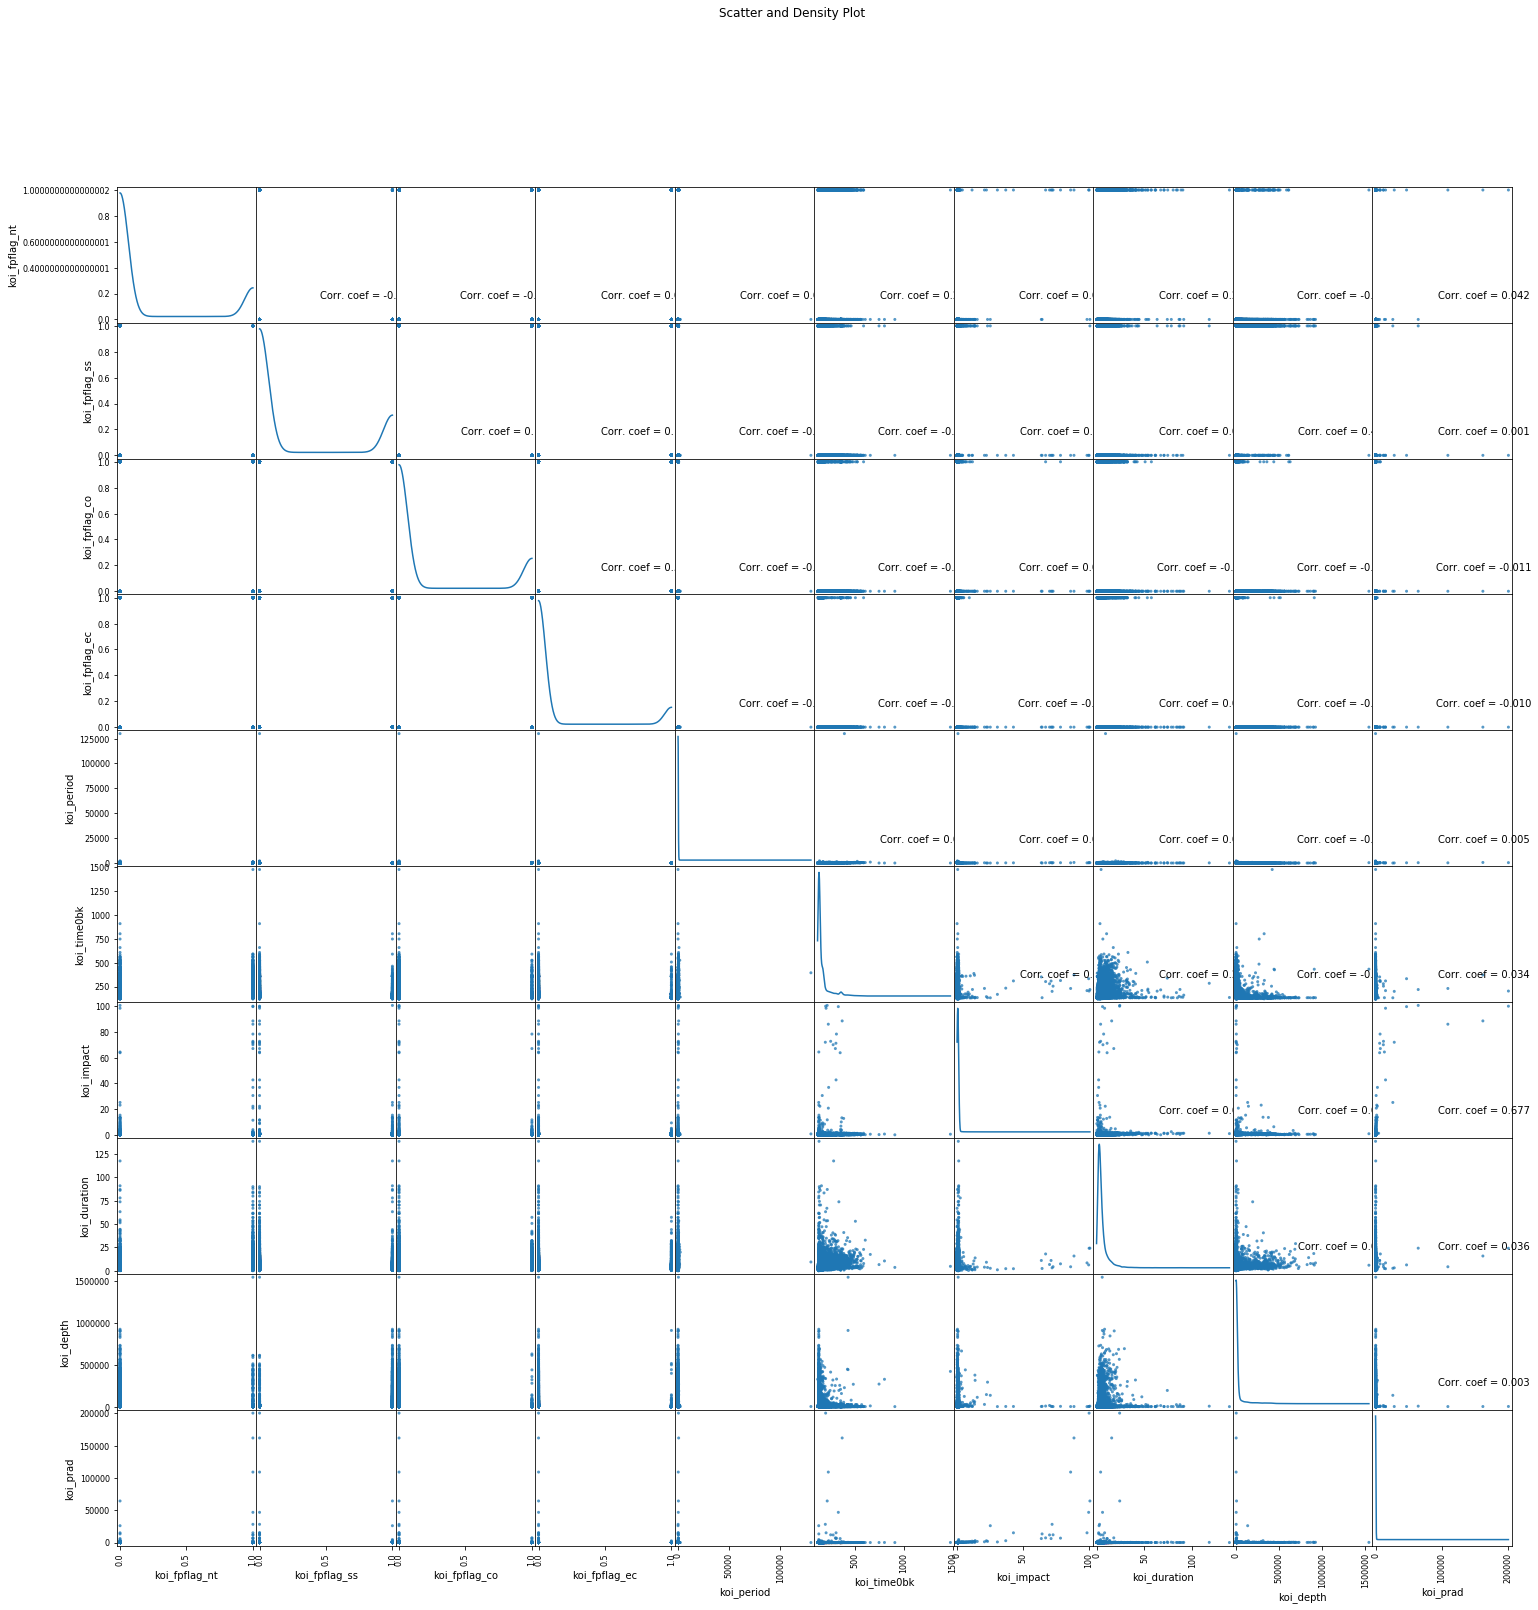

In [15]:
plotScatterMatrix(dataset_dropped_filled, 25, 10)

## Split the data into traning and testing set

<b>Note: </b> At this point:
- The variable "dataset" stores the raw data
- The variable "dataset_dropped" stores the data with some columns dropped
- The variable "dataset_dropped_filled" stores the data with some columns dropped and empty values filled with the mean 

The next step is to create the features matrix by dropping the labels column (i.e. koi_disposition) from the dataset and take that column as our labels

In [16]:
X = dataset_dropped_filled.drop(['koi_disposition'], axis = 1)
y = dataset_dropped_filled['koi_disposition']

In [17]:
X.shape

(9564, 19)

In [18]:
y.shape

(9564,)

In order for the classifier to work, we need to encode our labels. Since we are trying to create a classifier that predict if koi_disposition == CONFIRMED, we label all 'CONFIRMED' values in the column as 1 and the others as 0.

In [19]:
y.replace(to_replace = ['FALSE POSITIVE', 'CANDIDATE'], value = 0, inplace = True)
y.replace(to_replace = ['CONFIRMED'], value = 1, inplace = True)

In [20]:
y.head(10)

0    1
1    1
2    0
3    0
4    1
5    1
6    1
7    1
8    0
9    1
Name: koi_disposition, dtype: int64

Now that we have our features matrix and our labels for the classifier, we need to split our data into traning set and test set. The test size will be 20% of the whole dataset.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
X_train.shape

(7651, 19)

In [23]:
X_test.shape

(1913, 19)

In [24]:
y_train.value_counts()

0    5812
1    1839
Name: koi_disposition, dtype: int64

In [25]:
y_test.value_counts()

0    1459
1     454
Name: koi_disposition, dtype: int64

As mentioned earlier, we need to do some feature scaling so that our classifier can have the best performance, let's do that now

In [26]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Build and train our classifier

Now that we have our training data ready, let's build our classifier using Stochastic Gradient Descent (SGD)

In [27]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Let's take a look at the performance of our model, start with the accuracy.

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv = 5, scoring = "accuracy")

array([0.80404964, 0.80274331, 0.77320261, 0.80261438, 0.81425768])

Not too bad, but let's be more careful and take a look at the precision and recall score.

In [29]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 5)

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[5265,  547],
       [ 988,  851]], dtype=int64)

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred) 
print('The precision score of the model is: ', precision)
print('The recall score of the model is: ', recall)
print('The f1 score of the model is: ', f1)

The precision score of the model is:  0.6087267525035766
The recall score of the model is:  0.46275149537792276
The f1 score of the model is:  0.5257954896509114


Oops... this is pretty bad... Let's use Grid Search to find better hyperparameters for our model. Since the recall score was the worst, let's run the Grid Search with scoring = 'recall'

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2], # learning rate
    'max_iter': [1000, 1500, 2000], # number of maximum iterations
    'penalty': ['elasticnet', 'l1', 'l2'], # the penalty (a.k.a. regularisation term) to be used
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1], # the Elastic Net mixing parameter.
}

grid_search = GridSearchCV(sgd_clf, param_grid, scoring = 'recall', cv = 5, verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 567 candidates, totalling 2835 fits
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.500, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.470, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.188, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.486, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.670, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1, score=0.856, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1, score=0.361, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1, score=0.658, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1, score=0.622, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l1, score=0.515, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l2 .............
[CV]  alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l2, score=0.500, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0, max_iter=1000, penalty=l2 

[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1000, penalty=l2, score=0.486, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1000, penalty=l2, score=0.670, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet ..
[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet, score=0.682, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet ..
[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet, score=0.845, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet ..
[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet, score=0.663, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet ..
[CV]  alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet, score=0.938, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.05, max_iter=1500, penalty=elasticnet ..
[CV]  al

[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.856, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.361, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.658, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.622, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.515, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l2 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l2, score=0.500, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=1500, penalty=l2 ...........
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=150

[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=1500, penalty=l2, score=0.670, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.633, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.861, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.704, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.250, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.368, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.2, max_iter=2000, penalty=l1 ...........
[CV]  

[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.856, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.361, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.658, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.622, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.515, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l2, score=0.500, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=200

[CV]  alpha=0.0001, l1_ratio=0.8, max_iter=2000, penalty=l2, score=0.670, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, score=0.772, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, score=0.804, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, score=0.812, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, score=0.408, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet ...
[CV]  alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=elasticnet, score=0.455, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.9, max_iter=1000, penalty=l1 ...........
[CV]  

[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.622, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l1 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.515, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2, score=0.500, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2, score=0.470, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2, score=0.188, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2, score=0.486, total=   0.0s
[CV] alpha=0.0001, l1_ratio=0.95, max_iter=1000, penalty=l2 ..........
[CV]  alpha=0.0001, l1_ratio=0.95, max_i

[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=elasticnet, score=0.622, total=   0.0s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=elasticnet, score=0.515, total=   0.0s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1, score=0.856, total=   0.1s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1, score=0.361, total=   0.0s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1, score=0.658, total=   0.0s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1, score=0.622, total=   0.1s
[CV] alpha=0.0001, l1_ratio=1, max_iter=1500, penalty=l1 .............
[CV]  alpha=0.0001, l1_ratio=1, max_iter=1

[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.576, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.677, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.519, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.616, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=l1, score=0.840, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.001, l1_ratio=0, max_iter=2000, penalty=l1, score=0.709, total=   0.0s
[CV] alpha=0.001, l1_ratio=0, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.001, l1_ratio=0, m

[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l1, score=0.875, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2, score=0.826, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2, score=0.576, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2, score=0.677, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2, score=0.519, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.05, max_iter=2000, penalty=l2, score=0.616, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.1, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.1, max_iter=1000

[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l1, score=0.745, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l1, score=0.818, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l1, score=0.875, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.826, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.576, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.677, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.2, max_iter=1000, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.2, max_iter=1000, pena

[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.616, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.649, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.603, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.717, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.685, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.809, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=1500, penalty=l1 ............
[CV]  alpha=

[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l1, score=0.818, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l1 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l1, score=0.875, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.826, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.576, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.677, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.519, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.8, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.001, l1_ratio=0.8, max_iter=1500, pena

[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet, score=0.796, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet, score=0.696, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet, score=0.734, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet, score=0.750, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet ....
[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=elasticnet, score=0.711, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=l1 ............
[CV]  alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=l1, score=0.840, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.9, max_iter=2000, penalty=l1 ............
[CV]  alpha=

[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.709, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.745, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.818, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.875, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l2, score=0.826, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l2, score=0.576, total=   0.0s
[CV] alpha=0.001, l1_ratio=0.95, max_iter=2000, penalty=l2 ...........
[CV]  alpha=0.001, l1_ratio=0.95, max_iter=200

[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l1, score=0.236, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l1 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l1, score=0.286, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2, score=0.543, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2, score=0.356, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2, score=0.432, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2, score=0.470, total=   0.0s
[CV] alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=0, max_iter=1000, penalty=l2, score=0.428, 

[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l1, score=0.236, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l1, score=0.286, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.543, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.356, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.432, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.470, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.05, max_iter=1500, penalty=l2 ............
[CV]  alpha=0.01, l1_ratio=0.05, max_iter=1500, pena

[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l1, score=0.310, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l1, score=0.236, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l1, score=0.286, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.543, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.356, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.432, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=2000, penalty=l2,

[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.432, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.470, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1000, penalty=l2 .............
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.428, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.383, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.269, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet, score=0.348, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.5, ma

[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.277, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.274, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.291, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.310, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet .....
[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.300, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=l1, score=0.326, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.01, 

[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.212, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.286, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.326, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.326, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.310, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.236, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.95, max_iter=1000, penalty=l1 ............
[CV]  alpha=0.01, l1_ratio=0.95, max

[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l1, score=0.310, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l1 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l1, score=0.236, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l1 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l1, score=0.286, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2, score=0.543, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2, score=0.356, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2, score=0.432, total=   0.0s
[CV] alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2 ...............
[CV]  alpha=0.01, l1_ratio=1, max_iter=1500, penalty=l2, score=0.470, 

[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.05, max_iter=1000, penalty=l2 .............
[CV]  alpha=0.1, l1_ratio=0.05, max_iter=1000, pen

[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.1, max_iter=1500, penalty=l2, score=

[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.2, max_iter=2000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.2, max_iter=2000, pe

[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.8, max_iter=1000, penalty=l2, score=

[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l2 ..............
[CV]  alpha=0.1, l1_ratio=0.9, max_iter=1500, penalty=l2, score=

[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.95, max_iter=2000, penalty=l2 .............
[CV]  alpha=0.1, l1_ratio=0.95, max_iter=2000, pen

[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l2 ................
[CV]  alpha=1.0, l1_ratio=0, max_iter=1000, penalty=l2, score=0.000,

[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l1 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2 .............
[CV]  alpha=1.0, l1_ratio=0.05, max_iter=1500, penalty=l2,

[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l1 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.1, max_iter=2000, penalty=l2, score=

[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l1 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.5, max_iter=1000, penalty=l2, score=

[CV]  alpha=1.0, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=1500, penalty=l2 ..............
[CV]  alpha=1.0, l1_ratio=0.8, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=1.0, l1_ratio=0.8, m

[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1 .............
[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1 .............
[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1 .............
[CV]  alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=0.95, max_iter=1000, penalty=l1 .............
[CV]  alpha=1.0, l1_ratio=0.95, ma

[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l1 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2 ................
[CV]  alpha=1.0, l1_ratio=1, max_iter=1500, penalty=l2, score=0.000, total= 

[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=elasticnet .......
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=0, max_iter=2000, penalty=l

[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.1, max_iter=1000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.1, ma

[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1000, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1000, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.2, ma

[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1, score=0.000, total=   0.1s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.5, max_iter=1500, penalty=l2,

[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet .....
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.8, max_iter=2000, penalty=l1 .............
[CV]  alpha=10.0, l1_ratio=0.8, max_iter=2

[CV]  alpha=10.0, l1_ratio=0.9, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.9, max_iter=2000, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.9, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.9, max_iter=2000, penalty=l2 .............
[CV]  alpha=10.0, l1_ratio=0.9, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=0.95, max_iter=1000, penalty=elasticnet ....
[CV]  alpha=10.0, l1_ratio=0.95

[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l1, score=0.000, total=   0.1s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l1 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2 ...............
[CV]  alpha=10.0, l1_ratio=1, max_iter=1000, penalty=l2, score=0.000, 

[CV]  alpha=100.0, l1_ratio=0, max_iter=1500, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet ......
[CV]  alpha=100.0, l1_ratio=0, max_iter=2000, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0, max_iter=2000, penalty=l1 ..............
[CV]  alpha=100.0, l1_ra

[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.1, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.1, max_iter=1000, pena

[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.2, max_iter=1500, penalty=l1 ............
[CV]  alpha=100.0, l

[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l1, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l1 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.5, max_iter=2000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.5, max_iter=2000, pena

[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2 ............
[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1000, penalty=l2, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.9, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.9, max_iter=1500, penalty=elasticnet ....
[CV]  alpha=100.0, l1_ratio=0.9, max

[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=elasticnet, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=elasticnet ...
[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=elasticnet, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1 ...........
[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1 ...........
[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1, score=0.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1 ...........
[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1 ...........
[CV]  alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=0.95, max_iter=1500, penalty=l1 ...........
[CV]  alpha=100.0, l1_ratio=0.

[CV]  alpha=100.0, l1_ratio=1, max_iter=2000, penalty=l2, score=1.000, total=   0.0s
[CV] alpha=100.0, l1_ratio=1, max_iter=2000, penalty=l2 ..............
[CV]  alpha=100.0, l1_ratio=1, max_iter=2000, penalty=l2, score=0.000, total=   0.0s


[Parallel(n_jobs=1)]: Done 2835 out of 2835 | elapsed:   47.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=42,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95,
                                      1],
 

In [33]:
grid_search.best_params_

{'alpha': 0.001, 'l1_ratio': 0, 'max_iter': 1000, 'penalty': 'l1'}

In [34]:
grid_search.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [35]:
grid_search.best_score_

0.7971984175922704

Now that we have our new hyperparameters, let's train our model again and examine its performance

In [36]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(alpha = 0.001, l1_ratio = 0, penalty = 'l1', random_state = 42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.80791846, 0.82470588, 0.80784314])

In [38]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv = 5)

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[4755, 1057],
       [ 373, 1466]], dtype=int64)

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred) 
print('The precision score of the model is: ', precision)
print('The recall score of the model is: ', recall)
print('The f1 score of the model is: ', f1)

The precision score of the model is:  0.5810543004359889
The recall score of the model is:  0.7971723762914628
The f1 score of the model is:  0.6721687299403943


Ah, there we go, much better! The recall and f1 score has improved significantly, however, the precision score is slightly decreased. There is a tradeoff between the precision and recall score, and to know what is the best threshold to use, let's examine the threshold curve

In [41]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv = 5, method = "decision_function")

In [42]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

The following method plots the curve of precision & recall vs threshold and the code was adapted from the chapter 3's notebook of Hands on Machine Learning

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.title('Precision & Recall vs Threshold')
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

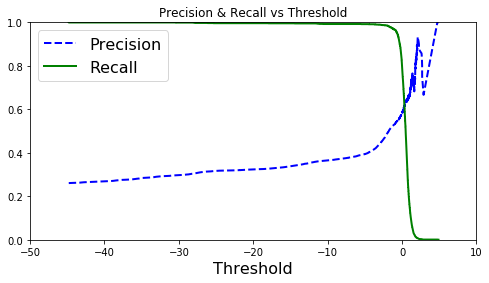

In [44]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-50, 10])
plt.show()

The following method plots the curve of precision vs recall and the code was adapted from the chapter 3's notebook of Hands on Machine Learning

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.title('Precision vs Recall')
    plt.axis([0, 1, 0, 1])

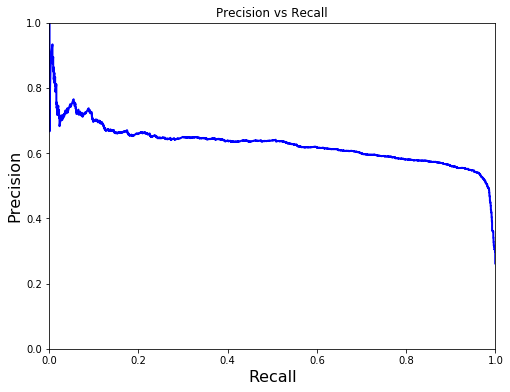

In [46]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Let's also plot the receiver operating characteristic (ROC) curve to see what it has

In [47]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

The following method plots the ROC curve and the code was adapted from the chapter 3's notebook of Hands on Machine Learning

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curve')

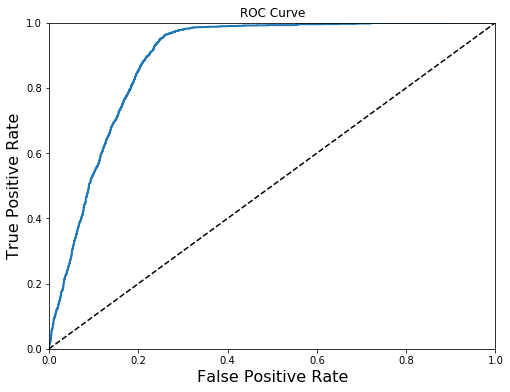

In [49]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [50]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.8891216051094527

<b>Observation: </b> a perfect classifier would have a ROC area under curve (AUC) equals to 1, and our classifier has the score of 0.899 which is a good sign!

## Evaluate the model

Now we have trained the best model so far, let's test it on the test set.

In [51]:
y_test_pred = sgd_clf.predict(X_test)

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred) 
print('The precision score of the model is: ', precision)
print('The recall score of the model is: ', recall)
print('The f1 score of the model is: ', f1)

The precision score of the model is:  0.6213592233009708
The recall score of the model is:  0.7048458149779736
The f1 score of the model is:  0.6604747162022704


Well, not too bad, I was expecting something around 0.5 for the scores but it turns out better, and this is also a wrap-up for our SGD Classifier :)